<a href="https://colab.research.google.com/github/ryanou97/stock_predict_with_RNN/blob/main/stock_predict_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## twstock 台股資料
若無資料來源，可用台灣證券交易所的twstock套件抓取。不過沒辦法抓取整年，且每個IP有流量限制。


In [60]:
!pip install twstock

import twstock

In [61]:
TSMC_stock = twstock.Stock('2330')

# 前一日資料
print("日期：",TSMC_stock.date[-1])
print("開盤價：",TSMC_stock.open[-1])
print("最高價：",TSMC_stock.high[-1])
print("最低價：",TSMC_stock.low[-1])
print("收盤價：",TSMC_stock.price[-1])

print(TSMC_stock.fetch(2023,1)) # 2023.1的資料

日期： 2023-11-13 00:00:00
開盤價： 579.0
最高價： 580.0
最低價： 571.0
收盤價： 571.0
[Data(date=datetime.datetime(2023, 1, 3, 0, 0), capacity=15311364, turnover=6871973708, open=446.0, high=453.5, low=443.0, close=453.0, change=4.5, transaction=22581), Data(date=datetime.datetime(2023, 1, 4, 0, 0), capacity=20626874, turnover=9310050329, open=449.5, high=455.0, low=448.5, close=449.5, change=-3.5, transaction=18233), Data(date=datetime.datetime(2023, 1, 5, 0, 0), capacity=23972099, turnover=10972616269, open=459.0, high=459.5, low=455.0, close=458.5, change=9.0, transaction=20752), Data(date=datetime.datetime(2023, 1, 6, 0, 0), capacity=21313593, turnover=9745142549, open=455.0, high=459.5, low=455.0, close=458.5, change=0.0, transaction=16635), Data(date=datetime.datetime(2023, 1, 9, 0, 0), capacity=49186355, turnover=23352375299, open=468.0, high=481.0, low=467.5, close=481.0, change=22.5, transaction=57305), Data(date=datetime.datetime(2023, 1, 10, 0, 0), capacity=34785370, turnover=16867391241, ope

## 資料前處理


### import必要套件、讀取csv

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 資料為台積電2330 2008/4/10~2023/11/10，來源為康和證券
df = pd.read_csv('/content/2330.csv')

In [63]:
df_close = pd.DataFrame(df['Close'])
df_close

,Close
0,64.5
1,64.1
2,63.0
3,63.0
4,65.2
...,...
3836,550.0
3837,555.0
3838,556.0
3839,557.0


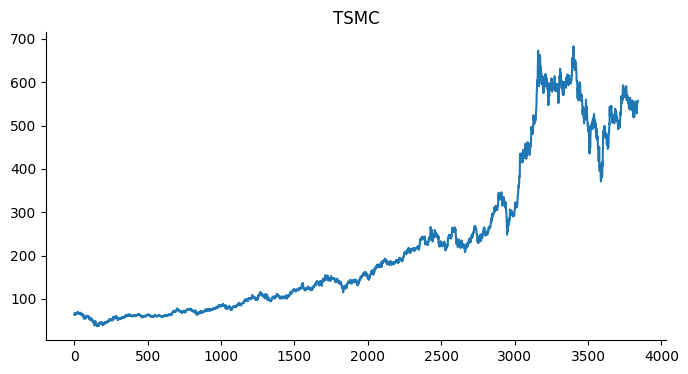

In [64]:
# 股價走勢

from matplotlib import pyplot as plt
df_close['Close'].plot(kind='line', figsize=(8, 4), title='TSMC')
plt.gca().spines[['top', 'right']].set_visible(False)

### 資料串列
前10天做為特徵，第11天做為標籤值，即用前10天的收盤價預測第11天的收盤價。

In [65]:
sequence_length = 10
data = []
for i in range(len(df_close) - sequence_length):
    data.append(df_close[i: i + sequence_length + 1])
print(data[0])

    Close
0    64.5
1    64.1
2    63.0
3    63.0
4    65.2
5    67.1
6    66.8
7    67.4
8    67.3
9    64.6
10   63.9


### 資料標準化
使用 MinMaxScaler() 把資料轉換到0~1之間

In [66]:
sequence_length = 10
df_close = MinMaxScaler().fit_transform(df_close)
data = []
for i in range(len(df_close) - sequence_length):
    data.append(df_close[i: i + sequence_length + 1])

## 分割訓練、測試資料
80%訓練、20%測試


In [67]:
reshaped_data = np.array(data)
x = reshaped_data[:, :-1]
y = reshaped_data[:, -1]

In [68]:
split_boundary = int(reshaped_data.shape[0] * 0.8)
train_x = x[: split_boundary]
test_x = x[split_boundary:]
train_y = y[: split_boundary]
test_y = y[split_boundary:]
print('training data：{}'.format(len(train_x)))
print('testing data：{}'.format(len(test_x)))

training data：3064
testing data：767


## RNN 建立與訓練

### 建立模型、LSTM層

In [69]:
model = Sequential()
model.add(LSTM(input_shape=(10,1), units=256, unroll=False))

### 輸出層

In [70]:
model.add(Dense(units=1))

### 查看權重數量
權重數量 = g * (n * (n+1) + n)

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               264192    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 訓練、儲存模型

In [72]:
model.compile(loss="mse", optimizer="adam",
              metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=100,
          epochs=100, validation_split=0.2,
          verbose=2)

model.save('/content/stock_model.keras')

Epoch 1/100
25/25 - 3s - loss: 0.0028 - accuracy: 4.0800e-04 - val_loss: 2.1161e-04 - val_accuracy: 0.0000e+00 - 3s/epoch - 118ms/step
Epoch 2/100
25/25 - 0s - loss: 9.1755e-05 - accuracy: 4.0800e-04 - val_loss: 2.2250e-04 - val_accuracy: 0.0000e+00 - 188ms/epoch - 8ms/step
Epoch 3/100
25/25 - 0s - loss: 2.5849e-05 - accuracy: 4.0800e-04 - val_loss: 2.0451e-04 - val_accuracy: 0.0000e+00 - 201ms/epoch - 8ms/step
Epoch 4/100
25/25 - 0s - loss: 2.0980e-05 - accuracy: 4.0800e-04 - val_loss: 1.9269e-04 - val_accuracy: 0.0000e+00 - 216ms/epoch - 9ms/step
Epoch 5/100
25/25 - 0s - loss: 2.0931e-05 - accuracy: 4.0800e-04 - val_loss: 1.8951e-04 - val_accuracy: 0.0000e+00 - 205ms/epoch - 8ms/step
Epoch 6/100
25/25 - 0s - loss: 2.0301e-05 - accuracy: 4.0800e-04 - val_loss: 2.0424e-04 - val_accuracy: 0.0000e+00 - 156ms/epoch - 6ms/step
Epoch 7/100
25/25 - 0s - loss: 2.0922e-05 - accuracy: 4.0800e-04 - val_loss: 1.9072e-04 - val_accuracy: 0.0000e+00 - 158ms/epoch - 6ms/step
Epoch 8/100
25/25 - 0s - 

## 預測股票收盤價

24/24 [==============================] - 0s 3ms/step


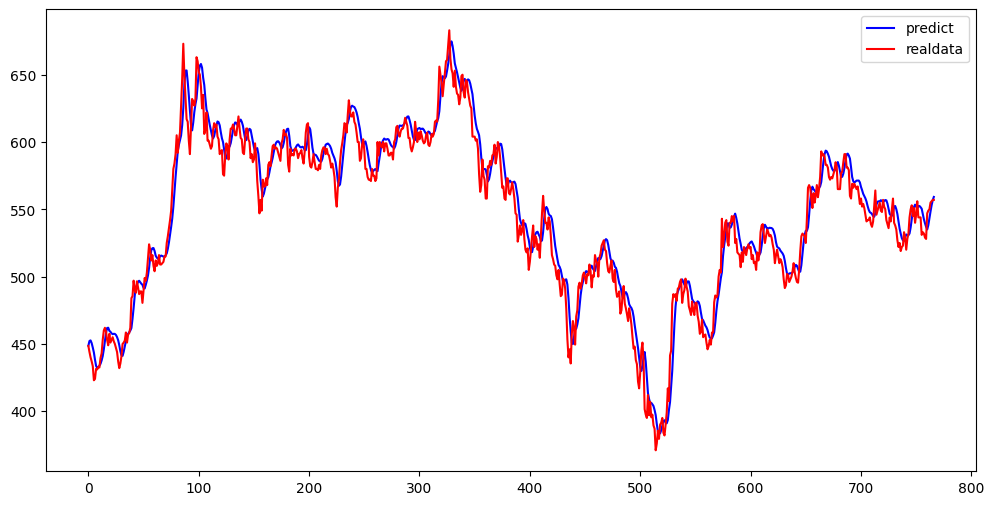

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

df = pd.read_csv('/content/2330.csv')
df_close = pd.DataFrame(df['Close'])
sequence_length = 10
scaler = MinMaxScaler()
df_close = scaler.fit_transform(df_close)
data = []
for i in range(len(df_close) - sequence_length):
    data.append(df_close[i: i + sequence_length + 1])
reshaped_data = np.array(data)
x = reshaped_data[:, :-1]
y = reshaped_data[:, -1]
split_boundary = int(reshaped_data.shape[0] * 0.8)
train_x = x[: split_boundary]
test_x = x[split_boundary:]
train_y = y[: split_boundary]
test_y = y[split_boundary:]

# 訓練好的模型
model = load_model('stock_model.keras')
predict = model.predict(test_x)
predict = scaler.inverse_transform(predict)
test_y = scaler.inverse_transform(test_y)

plt.figure(figsize=(12,6))
plt.plot(predict, 'b-')
plt.plot(test_y, 'r-')
plt.legend(['predict', 'realdata'])
plt.show()